# Cell segmentation on STARmap dataset

In [8]:
import spateo as st
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns

Read in data and change to input file for Starro

In [4]:
df0 = pd.read_csv('starmap.spot.csv')
df0.columns = ['geneID', 'x', 'y', 'z', 'gene', 'clustermap']
df = df0[['x', 'y', 'geneID']]
df['MIDCount'] = 1
df['EXONIC'] = 1
df['INTRONIC'] = 1
df

,x,y,geneID,MIDCount,EXONIC,INTRONIC
0,105,239,Syndig1l,1,1,1
1,110,243,Syndig1l,1,1,1
2,115,178,Acot13,1,1,1
3,117,246,Syndig1l,1,1,1
4,120,190,Map2k1,1,1,1
...,...,...,...,...,...,...
471290,13623,6606,Lims2,1,1,1
471291,13690,6423,Apod,1,1,1
471292,13699,6268,Ppp1r3c,1,1,1
471293,13546,6682,Syt10,1,1,1


In [5]:
df.to_csv('starmap.by1.gem.gz', index=False, sep='\t')

## cell segmentation with DAPI image

In [9]:
image = cv2.imread("starmap.by1.reg.tif", 0)
image = st.cs.utils.scale_to_255(st.cs.utils.gaussian_blur(image, k=51))
cv2.imwrite('by1.reg.gblur.tif', image.astype(np.uint8))

True

Read in DAPI image and RNA signals

In [12]:
adata0 = st.io.read_bgi_agg('starmap.by1.gem.gz', 'by1.reg.gblur.tif', prealigned=True)
adata0

|-----? Assuming stain image was already aligned with the minimum x and y RNA coordinates. (prealinged=True)
|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


AnnData object with n_obs × n_vars = 13804 × 6912
    uns: '__type', 'pp', 'spatial'
    layers: 'stain', 'spliced', 'unspliced'

Cell segmentation with StarDist

In [15]:
st.cs.stardist(adata0, tilesize=-1, equalize=2.0, out_layer='stardist_labels')

|-----> <select> stain layer in AnnData Object
|-----> Equalizing image with CLAHE.
|-----> Running StarDist with model 2D_versatile_fluo.
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
1/1 [==============================] - 9s 9s/step
|-----> Fixing disconnected labels.
|-----> <insert> stardist_labels to layers in AnnData Object.


In [16]:
st.cs.utils.filter_cell_labels_by_area(adata0, "stardist_labels", 3000)

|-----> <select> stardist_labels layer in AnnData Object
|-----> Cell number before filtering is 14805
|-----> <insert> stardist_labels to layers in AnnData Object.
|-----> Cell number after filtering is 1583


In [17]:
def get_cell_signal_intensity(adata, layer):
    df = pd.DataFrame({'cell':adata.layers[layer][adata.layers[layer]>0], 'signal_intensity': adata.layers['stain'][adata.layers[layer]>0]})
    df = df.groupby('cell').agg(np.mean)
    return df

In [18]:
stardist_df = get_cell_signal_intensity(adata0, 'stardist_labels')

<AxesSubplot:xlabel='signal_intensity', ylabel='Density'>

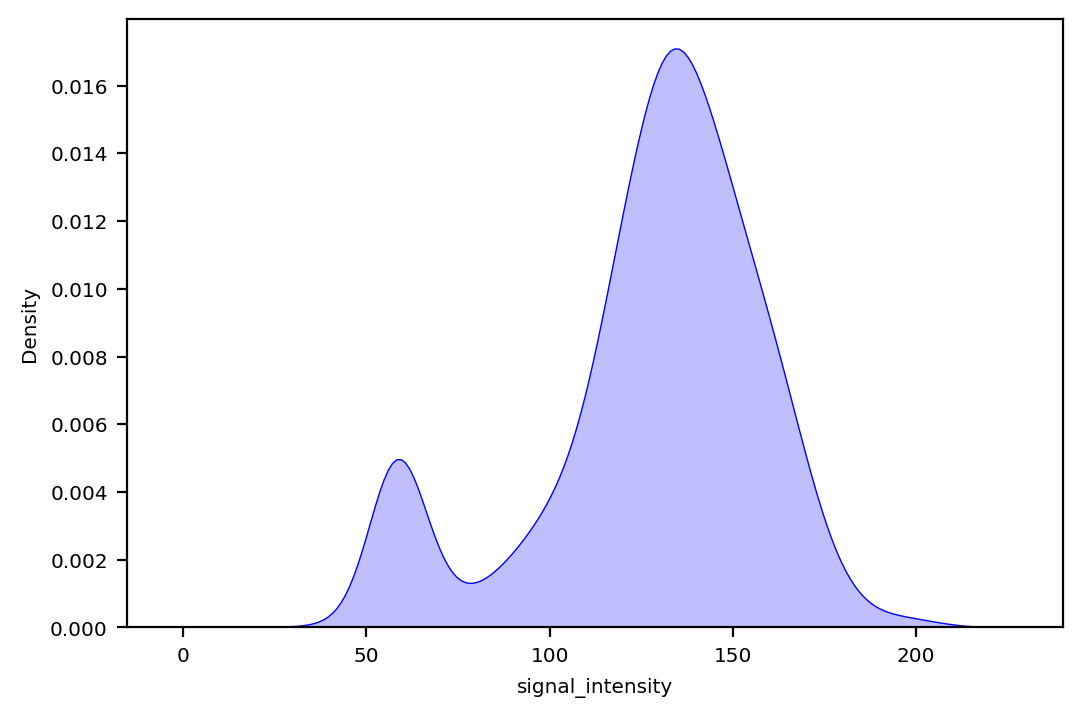

In [19]:
sns.kdeplot(stardist_df['signal_intensity'], color='blue', fill=True,)

Remove cells with low DAPI intensities

In [20]:
remove_cells = stardist_df[stardist_df['signal_intensity']<70].index
adata0.layers['stardist_labels'][np.isin(adata0.layers['stardist_labels'], remove_cells)] = 0

In [21]:
len(remove_cells)

161

## cell segmentation with RNA signals and adjust seeding step by previous stardist_labels

In [23]:
adata1 = st.io.read_bgi_agg('starmap.by1.gem.gz')
adata1

|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


AnnData object with n_obs × n_vars = 13804 × 6912
    uns: '__type', 'pp', 'spatial'
    layers: 'spliced', 'unspliced'

In [24]:
st.cs.score_and_mask_pixels(
    adata1, 'X', k=31, method='gauss',mk=31,
)

|-----> <select> X layer in AnnData Object
|-----> Scoring pixels with gauss method.
|-----> <insert> X_scores to layers in AnnData Object.
|-----> Applying threshold 0.111328125.
threshold: 0.111328125
|-----> <insert> X_mask to layers in AnnData Object.


In [37]:
st.cs.label_connected_components(adata1, layer='X_mask', area_threshold=1000000, out_layer='rna_markers', n_iter=0)

|-----> <select> X_mask layer in AnnData Object
|-----> <insert> rna_markers to layers in AnnData Object.


In [38]:
def a_specific_than_b(a, b):
    a_spe_cans = a[(a>0) & (b==0)]
    a_spe_counts = np.bincount(a_spe_cans)
    a_counts = np.bincount(a.flatten())
    a_spe_cells = np.where((a_spe_counts == a_counts[0:len(a_spe_counts)]) & (a_spe_counts>0))[0]
    return a_spe_cells

RNA specific labels that do not exist on stardist_labels

In [39]:
rna_spe_labels = a_specific_than_b(adata1.layers['rna_markers'], adata0.layers['stardist_labels'])

Use stardist_labels to adjust RNA labels

In [40]:
adata1.layers['inter_markers'] = adata1.layers['rna_markers'].copy()
adata1.layers['inter_markers'][np.isin(adata1.layers['rna_markers'], rna_spe_labels, invert=True)] = 0
adata1.layers['inter_markers'] += np.where((adata0.layers['stardist_labels']>0) & (adata1.layers['rna_markers']>0), adata0.layers['stardist_labels']+np.max(rna_spe_labels), 0)

In [41]:
st.cs.watershed(adata1, 'X', k=121, mask_layer='X_mask', markers_layer='inter_markers', out_layer="inter_labels")
st.cs.utils.filter_cell_labels_by_area(adata1, "inter_labels", 1000)

|-----> <select> X layer in AnnData Object
|-----> <select> X_mask layer in AnnData Object
|-----> <select> inter_markers layer in AnnData Object
|-----> Running Watershed.
|-----? Some labels have area greater than 10000. If you are segmenting based on RNA, consider using `st.cs.label_connected_components` instead.
|-----> <insert> inter_labels to layers in AnnData Object.
|-----> <select> inter_labels layer in AnnData Object
|-----> Cell number before filtering is 1474
|-----> <insert> inter_labels to layers in AnnData Object.
|-----> Cell number after filtering is 1435


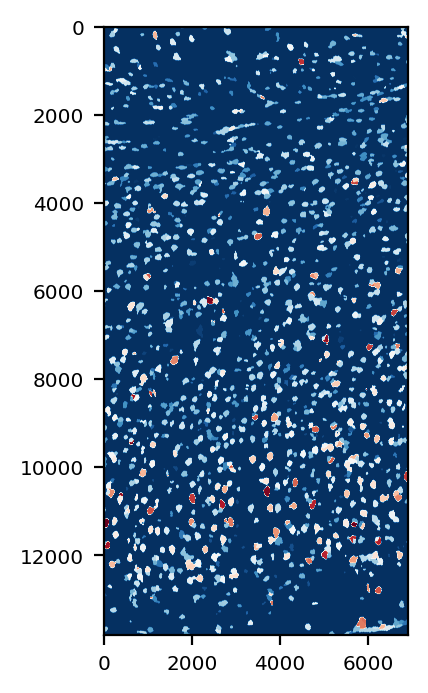

In [42]:
plt.imshow(adata1.layers['inter_labels'])